In [1]:
import sys
sys.path.append("../../smsl")

In [2]:
from smsl.multiWindows import SmallTimeAgent
from smsl.config import ConfAgent
from smsl.graph import BM
from smsl.plotAgent import SinglePlotAgent, palette

In [3]:
import os
import pandas as pd
import numpy as np
import re

In [4]:
class HotSpotAgent(dict, ConfAgent):
    def __init__(self, MAgent):
        ConfAgent.__init__(self)
        self.end_ns = self.time_num
        self.framesperns = self.frame_num // self.time_num
        self.MAgent = MAgent
    def load_systems(self, system2offical_name):
        ori_path = os.getcwd()
        for system, system_offical_name in system2offical_name.items():
            os.chdir(f'../../{system}/d.fluctmatch')
            st_agent = HsSmallTimeAgent(0, self.end_ns, self.framesperns, self.MAgent)
            st_agent.system_offical_name = system_offical_name
            self[system] = st_agent
        os.chdir(ori_path)
        self.m_abbr = st_agent.st_agent.m_abbr
    def extend_rirjs(self):
        for system, st_agent in self.items():
            st_agent.extend_rirjs()

class HsSmallTimeAgent(SmallTimeAgent):
    def __init__(self, beg_ns, end_ns, framesperns, MAgent):
        SmallTimeAgent.__init__(self, beg_ns, end_ns, framesperns)
        self.st_agent = MAgent(0, self.end_ns, self.framesperns)
        self.df_m = self.st_agent.df_m
    def get_rirjs(self, is_return=False):
        rirjs_str, rirjs = [], []
        resid_ion2layer = {2:['top','mid'], 1:['mid','bot']}
        for rj, layers in resid_ion2layer.items():
            for layer in layers:
                df_tetrad_layer = self.df_tetrad_geometry.loc[layer]
                for g_strand, ri in df_tetrad_layer.items():
                    k_rj = 3 - rj## resid_i=2 -> K1(top), resid_i=1 -> K2(bot) 
                    rirjs_str.append(f'G{ri}K{k_rj}') 
                    rirjs.append([ri, rj])
        if is_return:
            return rirjs_str, rirjs
        else:
            self.rirjs_str = rirjs_str
            self.rirjs     = rirjs
    def extend_rirjs(self, df_m=None):
        self.get_rirjs()
        if df_m is None:
            df_m = self.df_m
        for rirj_str, (ri, rj) in zip(self.rirjs_str, self.rirjs):
            df_sele = df_m.query(f'Resid_i=={ri} & Resid_j=={rj}')
            df_m.loc[df_sele.index, ['aiaj']] = df_sele['Atomname_i'] + df_sele['Atomname_j']
            df_m.loc[df_sele.index, ['rirj']] = rirj_str

In [5]:
system2offical_name = {
'propeller': 'Propeller',
'basket'   : 'Basket',
'chair'    : 'Chair',
'hybrid-i' : 'Hybrid-I',
'hybrid-ii': 'Hybrid-II',
# 'dsdna'    : 'dsDNA',
}

hs_agent = HotSpotAgent(BM)
hs_agent.load_systems(system2offical_name)
hs_agent.extend_rirjs()

Reading data from: /home/user/workfolder/g4dna_protocol_demo/propeller/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/basket/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/chair/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-i/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

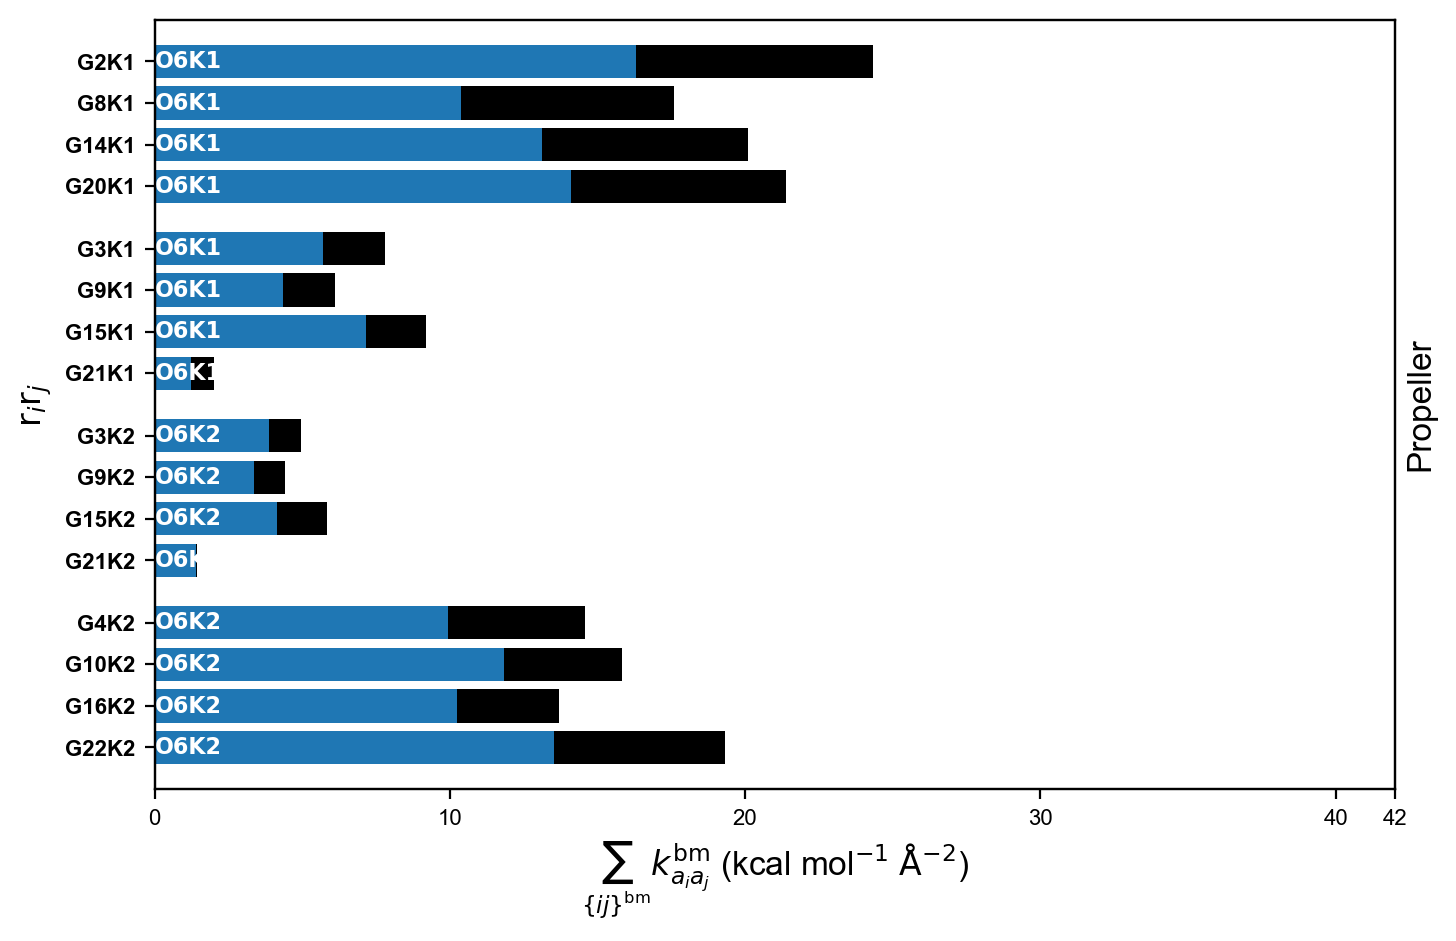

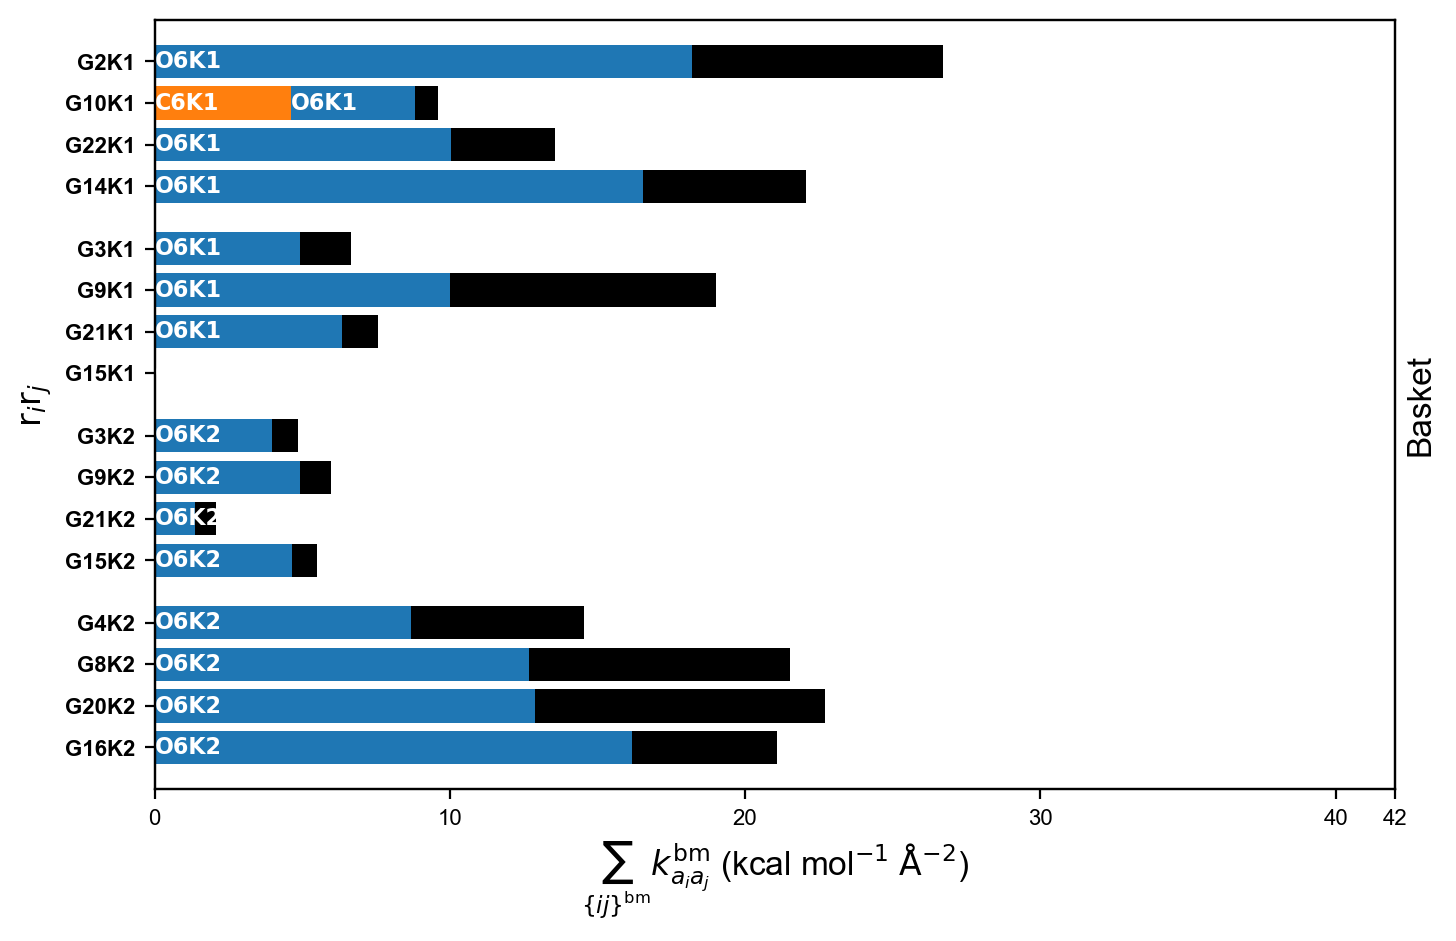

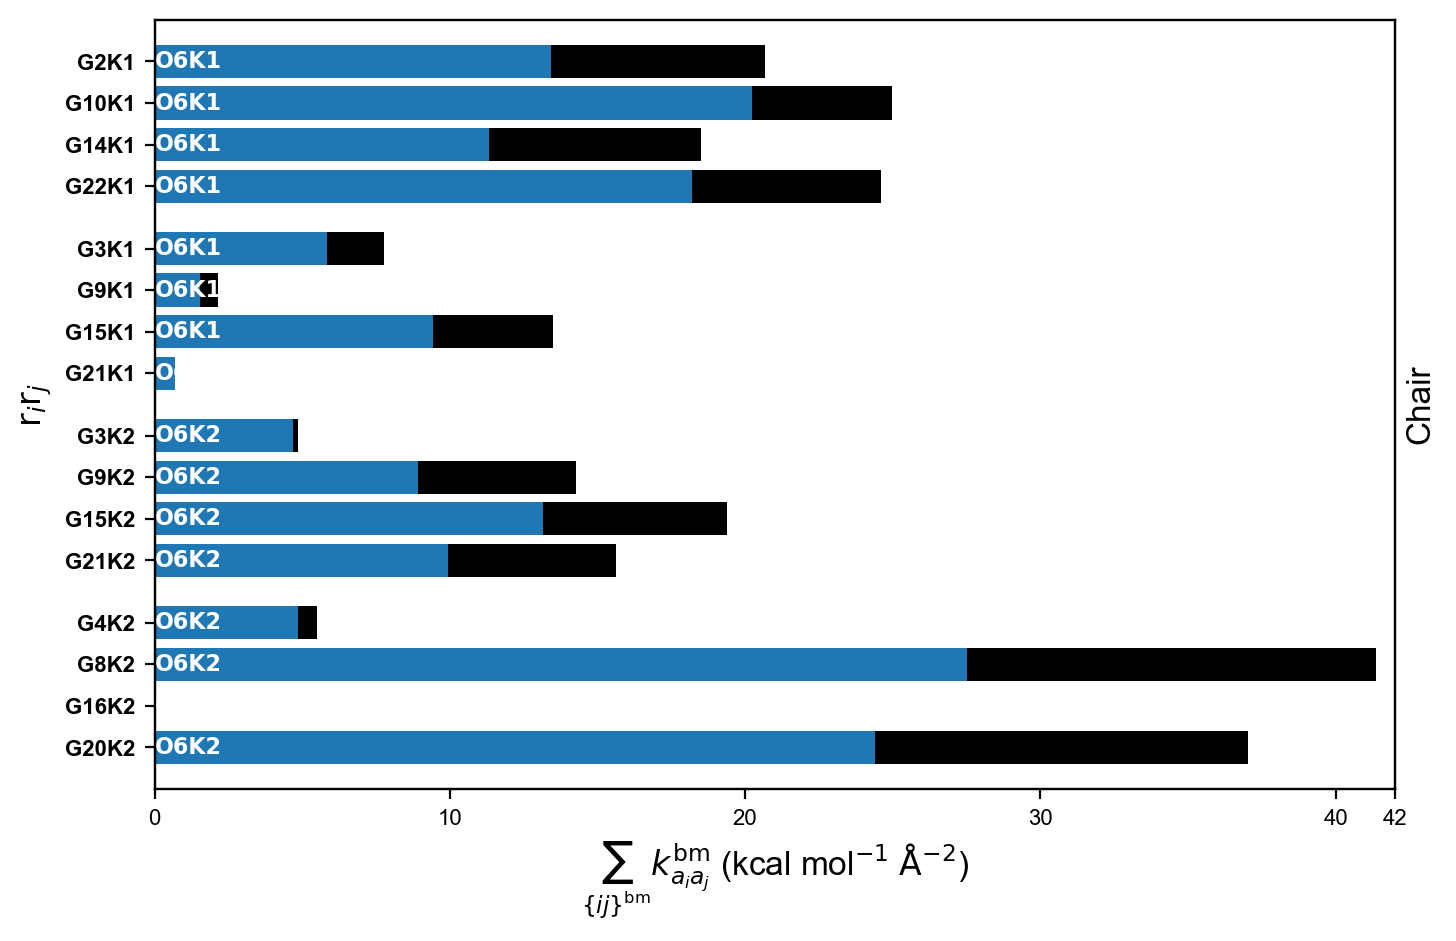

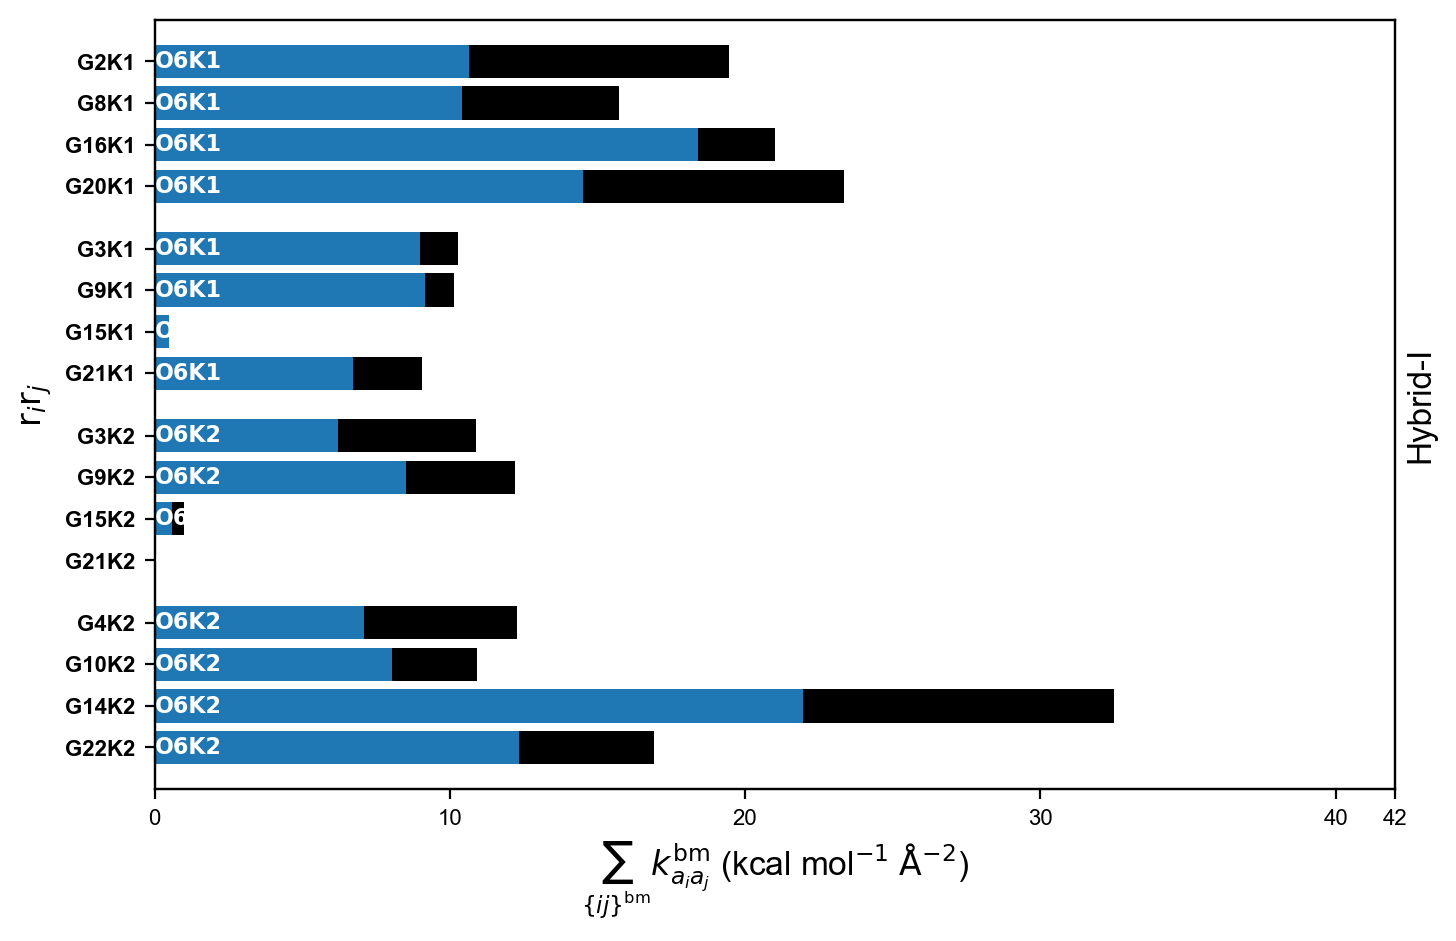

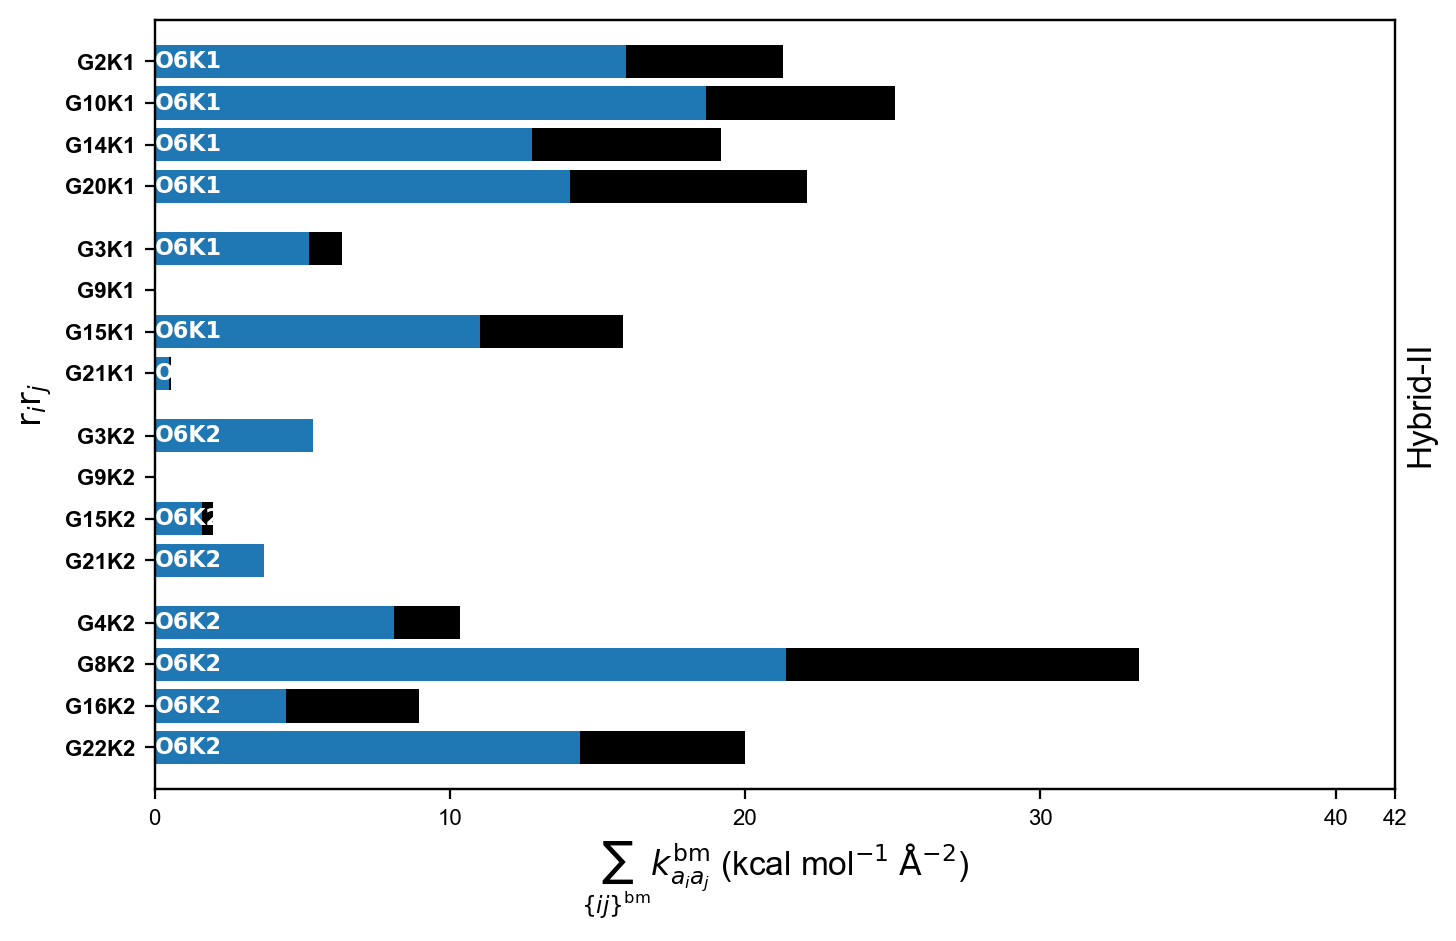

In [6]:
n_top = 1
height = 0.8

aiaj2color = {}
for system, st_agent in hs_agent.items():
    
    # Initialize left for each category
    n_repeat = 4
    lefts = {rirj_str: 0 for rirj_str in st_agent.rirjs_str}
    yticks = np.arange(0.0, len(st_agent.rirjs_str))[::-1]
    for y in range(n_repeat, len(yticks), n_repeat):
        yticks[:y] = yticks[:y] + 0.5
    rirj2ytick = dict(zip(st_agent.rirjs_str, yticks))

    # Sort the DataFrame by 'rirj' and 'k' (descending)
    df_sorted = st_agent.df_m.sort_values(by=['rirj', 'k'], ascending=[True, False])

    # Plot data
    figsize_y = 0.27 * (yticks[0] - yticks[-1] + 2)
    p_agent = SinglePlotAgent(figsize_1=[8.0, figsize_y])
    
    for rirj_str in st_agent.rirjs_str:
        # Filter sorted data for the current category
        df_sele = df_sorted[df_sorted['rirj'] == rirj_str]
        # Plot each segment with the cumulative left position
        for i, (_, df_iter) in enumerate(df_sele.iterrows()):
            if (i >= n_top) and (not 'O6' in df_iter['aiaj']):  ## (not topn) and (not O6POT)
                aiaj = ''
                color = 'black'
            else:
                aiaj = df_iter['aiaj']
                color = aiaj2color.get(aiaj)
                if color is None:
                    color = palette[len(aiaj2color)]
                    aiaj2color[aiaj] = color
                    p_agent.axs.plot([], [], label=aiaj, c=color)
            ## barplot
            p_agent.axs.barh(rirj2ytick[df_iter['rirj']], df_iter['k'], left=lefts[rirj_str], color=color, height=height)
            ## text
            x = lefts[rirj_str]
            y = rirj2ytick[df_iter['rirj']]
            # print(df_iter['k'], x)
            if aiaj != '': 
                ai = ''.join(re.findall(r"([A-Za-z]+)(\d+)", aiaj)[0])
                aj = ''.join(re.findall(r"([A-Za-z]+)(\d+)", rirj_str)[1])
                aiaj = ai + aj
                p_agent.axs.text(x, y, aiaj, ha='left', va='center', c='white', rotation=0, 
                             size=8, fontweight='bold', alpha=1.0)
            # Update left position for the next segment
            lefts[rirj_str] += df_iter['k']
    # print(lefts)

    # Add labels, title, and legend
    p_agent.set_xlabel(r'$\sum_{\{ij\}^{\rm{'+hs_agent.m_abbr+r'}}} k^{\rm{'+hs_agent.m_abbr+'}}_{a_ia_j}$'+r' (kcal mol$^{-1}$ $\rm{\AA}^{-2}$)', fontdict={'family': 'Arial', 'weight': 'normal', 'size': 12})
    p_agent.axs.set_ylabel(r'${\rm{r}}_{i}{\rm{r}}_{j}$', fontdict={'family': 'Arial', 'weight':'normal', 'size': 12})
    p_agent.set_ylabel(st_agent.system_offical_name, position='right')
    xticks = list(range(0, 41, 10)) + [42]
    p_agent.set_xticks(xticks, fontdict={'family': 'Arial', 'weight': 'normal', 'size': 8})
    p_agent.axs.set_yticks(yticks)
    p_agent.axs.set_yticklabels(st_agent.rirjs_str, fontdict={'family': 'Arial', 'weight': 'bold', 'size': 8})
    p_agent.axs.set_ylim(yticks[-1]-1.0, yticks[0]+1.0)
    p_agent.savefig(f'{hs_agent.m_abbr}_stacked_barplot.{st_agent.system_offical_name}_v2.svg')